In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# Using a pre-trained CNN (convnet) - "Transfer Learning"

* A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network 
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task.
If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a 
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these 
new problems might involve completely different classes from those of the original task.

* In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

* We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. 

* There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with **feature extraction**.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of convolution and pooling  
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" will simply consist of **taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output**.

<img src=https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png width=450>


Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on 
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new 
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the 
model to do feature extraction, rather than using the entire convolutional base.


Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, # do not use Dense of VGG16
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are** two ways we could proceed**: 

1.  (**FE1**) Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and 
cheap to run, because it only requires running the convolutional base **just once for every input image**. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

2.  (**FE2**) Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 
However, for this same reason, this technique is far more expensive than the first one.


## FE1 Method

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the **`predict`** method of the `conv_base` model.

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
# Python Review
import numpy as np
f1 = np.zeros((5,3))
print(f1)
f1[0:2] = np.array([[1,1,1],[2,2,2]])
print(f1)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 1. 1.]
 [2. 2. 2.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [6]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/gdrive/My Drive/cats_dogs_original_sm'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # <=== Why? output of block5_pool see above
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # <=========== !!!!
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000) # not used...

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 1s 460us/step - loss: 0.6006 - acc: 0.6580 - val_loss: 0.4421 - val_acc: 0.8360
Epoch 2/10
2000/2000 [==============================] - 1s 341us/step - loss: 0.4178 - acc: 0.8150 - val_loss: 0.3555 - val_acc: 0.8680
Epoch 3/10
2000/2000 [==============================] - 1s 343us/step - loss: 0.3380 - acc: 0.8610 - val_loss: 0.3133 - val_acc: 0.8830
Epoch 4/10
2000/2000 [==============================] - 1s 317us/step - loss: 0.2979 - acc: 0.8855 - val_loss: 0.2929 - val_acc: 0.8920
Epoch 5/10
2000/2000 [==============================] - 1s 327us/step - loss: 0.2754 - acc: 0.8935 - val_loss: 0.2789 - val_acc: 0.8890
Epoch 6/10
2000/2000 [==============================] - 1s

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

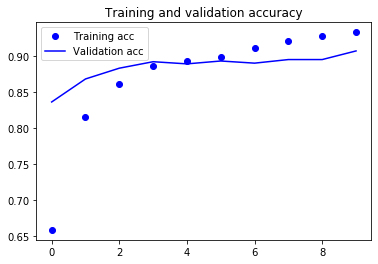

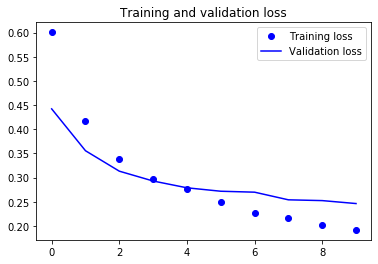

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from 
scratch. 
However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. 
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.


## FE2 Method

This is much slower and more expensive (GPU is a must), but which allows 
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs for # of epoches. 

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. 
So you can do the following:

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)              # <============ MUST BE FROZEN!!!
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [12]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
conv_base.trainable = False

In [14]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255) # Just rescale. No DA

train_generator = train_datagen.flow_from_directory( 
        train_dir,              # This is the target directory
        target_size=(150, 150), # All images will be resized to 150x150
        batch_size=20,
        class_mode='binary') # Since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator, # augmented images are fed
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator, # No DA
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
 - 24s - loss: 0.6143 - acc: 0.6730 - val_loss: 0.4741 - val_acc: 0.8130
Epoch 2/10
 - 21s - loss: 0.4928 - acc: 0.7705 - val_loss: 0.3852 - val_acc: 0.8500
Epoch 3/10
 - 21s - loss: 0.4282 - acc: 0.8130 - val_loss: 0.3392 - val_acc: 0.8610
Epoch 4/10
 - 21s - loss: 0.4138 - acc: 0.8180 - val_loss: 0.3154 - val_acc: 0.8810
Epoch 5/10
 - 21s - loss: 0.4008 - acc: 0.8210 - val_loss: 0.3006 - val_acc: 0.8840
Epoch 6/10
 - 21s - loss: 0.3702 - acc: 0.8380 - val_loss: 0.3003 - val_acc: 0.8780
Epoch 7/10
 - 21s - loss: 0.3594 - acc: 0.8405 - val_loss: 0.2810 - val_acc: 0.8880
Epoch 8/10
 - 21s - loss: 0.3380 - acc: 0.8620 - val_loss: 0.2759 - val_acc: 0.8850
Epoch 9/10
 - 21s - loss: 0.3430 - acc: 0.8420 - val_loss: 0.2702 - val_acc: 0.8910
Epoch 10/10
 - 21s - loss: 0.3308 - acc: 0.8550 - val_loss: 0.2624 - val_acc: 0.9000


In [0]:
model.save('CatsDogsSM_Pretrained_FE2.h5') # this will not stay there...
model.save('/gdrive/My Drive/Colab Notebooks/h5s/CatsDogsSM_Pretrained_FE2.h5')

Let's plot our results again:

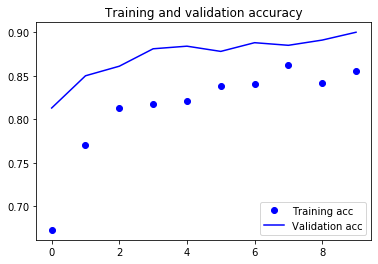

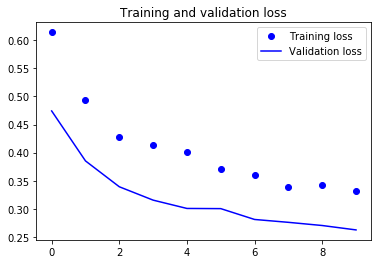

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We may reach a better validation accuracy.

## Evaluation 1: Get 20 test images. Display them. Present to the trained model. Compare the result with target labels.

Found 1000 images belonging to 2 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


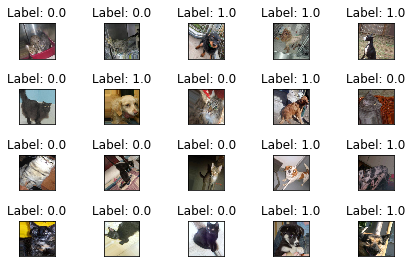

In [18]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# To get the 1st batch
for t_data_batch, t_labels_batch in train_generator:
    print('data batch shape:', t_data_batch.shape)
    print('labels batch shape:', t_labels_batch.shape)
    break

import matplotlib.pyplot as plt
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(t_data_batch[i],interpolation='none')
  plt.title("Label: {}".format(t_labels_batch[i]))
  plt.xticks([])
  plt.yticks([])

In [19]:
print("target labels:     ", t_labels_batch)
# present the image to the network
out = model.predict(t_data_batch) 
out = out.reshape(20,)
print("prediected labels: ", out.round())

target labels:      [0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.]
prediected labels:  [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


## Evaluation 2: Recreate the same model by reading the saved h5 file. Do the same testing as Evaluation 1 above

In [20]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('/gdrive/My Drive/Colab Notebooks/h5s/CatsDogsSM_Pretrained_FE2.h5')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [21]:
print("target labels:     ", t_labels_batch)
# present the image to the network
out = new_model.predict(t_data_batch) 
out = out.reshape(20,)
print("prediected labels: ", out.round())

target labels:      [0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.]
prediected labels:  [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


## Evaluation 3: Use model.evalute() with the whole validation & test datasets 

In [22]:
vali_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=1000,
        class_mode='binary')

for v_data_batch, v_labels_batch in vali_generator:
    print('data batch shape: ', v_data_batch.shape)
    print('label batch shape:', t_labels_batch.shape)
    break

Found 1000 images belonging to 2 classes.
data batch shape:  (1000, 150, 150, 3)
label batch shape: (20,)


In [23]:
loss, acc = new_model.evaluate(v_data_batch, v_labels_batch)
print("Using restored model, validation accuracy: {:5.2f}%".format(100*acc))

1000/1000 [==============================] - 2s 2ms/step
Using restored model, validation accuracy: 90.00%


In [24]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1000,
        class_mode='binary')

for t_data_batch, t_labels_batch in test_generator:
    print('data batch shape: ', t_data_batch.shape)
    print('label batch shape:', t_labels_batch.shape)
    break

Found 1000 images belonging to 2 classes.
data batch shape:  (1000, 150, 150, 3)
label batch shape: (1000,)


In [25]:
loss, acc = new_model.evaluate(t_data_batch, t_labels_batch)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 [==============================] - 1s 1ms/step
Restored model, accuracy: 88.60%


## HW11: Test FE1 method with dropout rate as 0.5. Currently 0.4
Austin Placinto
I have neither given nor received any unauthorized aid in completing this work, nor have I presented someone else's work as my own.

In [26]:
import keras
keras.__version__

'2.2.5'

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, # do not use Dense of VGG16
                  input_shape=(150, 150, 3))

In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [29]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [30]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/gdrive/My Drive/cats_dogs_original_sm'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # <=== Why? output of block5_pool see above
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # <=========== !!!!
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000) # not used...

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [32]:
from keras import models
from keras import layers
from keras import optimizers

model3 = models.Sequential()
model3.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model3.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 1s 580us/step - loss: 0.6158 - acc: 0.6550 - val_loss: 0.4463 - val_acc: 0.8450
Epoch 2/10
2000/2000 [==============================] - 1s 330us/step - loss: 0.4338 - acc: 0.8105 - val_loss: 0.3614 - val_acc: 0.8630
Epoch 3/10
2000/2000 [==============================] - 1s 314us/step - loss: 0.3497 - acc: 0.8475 - val_loss: 0.3322 - val_acc: 0.8610
Epoch 4/10
2000/2000 [==============================] - 1s 342us/step - loss: 0.3159 - acc: 0.8715 - val_loss: 0.3013 - val_acc: 0.8840
Epoch 5/10
2000/2000 [==============================] - 1s 321us/step - loss: 0.2791 - acc: 0.8885 - val_loss: 0.2944 - val_acc: 0.8830
Epoch 6/10
2000/2000 [==============================] - 1s 331us/step - loss: 0.2562 - acc: 0.9005 - val_loss: 0.2734 - val_acc: 0.8930
Epoch 7/10
2000/2000 [==============================] - 1s 311us/step - loss: 0.2454 - acc: 0.9105 - val_loss: 0.2689 - val_acc: 0.8910


In [0]:
model3.save('/gdrive/My Drive/Colab Notebooks/h5s/CatsDogsSM_Pretrained_FE3.h5')

In [34]:
test_loss, test_acc = model3.evaluate(test_features, test_labels)
test_acc

1000/1000 [==============================] - 0s 90us/step


0.882

## Homework 11b

In [35]:
# Recreate the exact same model, including weights and optimizer.
model4 = keras.models.load_model('/gdrive/My Drive/Colab Notebooks/h5s/CatsDogsSM_Pretrained_FE3.h5')
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [36]:
test_loss, test_acc = model4.evaluate(test_features, test_labels)
test_acc

ValueError: ignored